In [1]:
DATA_DIR = "D:/ml_data/stackexchange/"

import pandas as pd

In [2]:
csv_file = 'ai_Posts.csv'

ai_posts = pd.read_csv(csv_file)

def combine_title_and_body(title, body):
    # I'm having trouble getting over the fact that a missing string has a numeric type.
    if title==title: # not NaN
        text = title + ' ' + body
    elif body == body:
        text = body
    else:
        text = ''
    return str(text)

ai_posts['text'] = [ combine_title_and_body(row.title, row.body) for idx, row in ai_posts.iterrows()]

In [3]:
from sentence_transformers import SentenceTransformer
sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


import time
start = time.time()

ai_posts['vector'] = sentxformer.encode(ai_posts['text'].values).tolist()

end = time.time()
print(f'featurization took {end - start: 0.3f} seconds')

featurization took  328.353 seconds


In [4]:
featurized_file = DATA_DIR + csv_file.replace('.csv', '_featurized.csv')

ai_posts.to_csv(featurized_file, index=False) # ~400MB

# ai_posts = pd.read_csv(featurized_file)
# ai_posts['vector'] = [eval(v) for v in ai_posts['vector']]

ai_posts['tags']

0        neural-networks;backpropagation;terminology;de...
1        neural-networks;machine-learning;statistical-a...
2                                                      NaN
3        neural-networks;hyperparameter-optimization;ar...
4                 philosophy;definitions;intelligent-agent
                               ...                        
23174                                                  NaN
23175                                                  NaN
23176                                                  NaN
23177                             neural-networks;homework
23178              search;constraint-satisfaction-problems
Name: tags, Length: 23179, dtype: object

In [5]:
from collections import Counter

all_tags = []
for tag_str in ai_posts['tags'].values:
    if tag_str == tag_str: # not NaN
        tags = tag_str.split(';')
        all_tags.extend(tags)
    

len(all_tags) # 36223

Counter(all_tags).most_common(100)

[('neural-networks', 2333),
 ('reinforcement-learning', 2200),
 ('machine-learning', 2100),
 ('deep-learning', 1804),
 ('convolutional-neural-networks', 1067),
 ('natural-language-processing', 628),
 ('reference-request', 453),
 ('computer-vision', 450),
 ('deep-rl', 446),
 ('comparison', 430),
 ('classification', 426),
 ('training', 411),
 ('terminology', 376),
 ('q-learning', 354),
 ('recurrent-neural-networks', 334),
 ('python', 324),
 ('tensorflow', 320),
 ('dqn', 309),
 ('papers', 306),
 ('image-recognition', 278),
 ('long-short-term-memory', 270),
 ('ai-design', 265),
 ('datasets', 251),
 ('objective-functions', 250),
 ('keras', 240),
 ('game-ai', 238),
 ('backpropagation', 236),
 ('math', 227),
 ('generative-adversarial-networks', 220),
 ('object-detection', 210),
 ('optimization', 207),
 ('definitions', 197),
 ('gradient-descent', 188),
 ('transformer', 186),
 ('applications', 184),
 ('markov-decision-process', 183),
 ('pytorch', 180),
 ('philosophy', 179),
 ('agi', 178),
 ('po

In [6]:
# Choose a variety of interesting and reasonably common tags
target_tags = ['philosophy', 'proofs', 'q-learning', 'deep-rl',  'superintelligence', 'classification']

for tt in target_tags:
    flag_col = tt + '_flag'
    ai_posts[flag_col] = [1 if tt in str(tag_str) else 0 for tag_str in ai_posts['tags'].values]

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np

tag_name = 'classification'
flag_col = tag_name + '_flag'
score_col = tag_name + '_score'

X_all = [v for v in ai_posts['vector']]
y_all = [f for f in ai_posts[flag_col]]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25, random_state=42)

Cs = np.logspace(-4, 4, 5)

clf = LogisticRegressionCV(Cs=Cs, max_iter=10000)
clf.fit(X_train, y_train)

score_test = clf.predict_proba(X_test)[:,1]

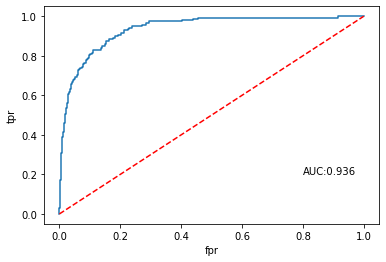

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_auc(labels, scores):
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

    auc = metrics.roc_auc_score(labels, scores)

    plt.plot(fpr, tpr)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot([0, 1], [0, 1],'r--')
    plt.text(0.8, 0.2, f"AUC:{auc:0.3f}")

plot_auc(y_test, score_test)

In [9]:
ai_posts[score_col] = clf.predict_proba(X_all)[:,1]

In [10]:
pd.set_option('display.max_colwidth', None)
show_cols = ['text', flag_col, score_col]

# Highest scoring examples that do not have the tag
ai_posts[ai_posts[flag_col]==0].sort_values(score_col, ascending=False).head(10)[show_cols]

,text,classification_flag,classification_score
21808,"Multiclass image classification - what approach to use and which models to consider? I'm working on an image classification project and I need to train a multiclass, multilabel classifier. The dataset is large and some of the images are mislabeled (for a given class, some labels are pretty easy to mix up). As an approach, I am using the following:\n\nConsidering the main available models, check their accuracy for the considered dataset at different learning rates. More in detail, my approach is to take a pretrained model, remove the last layer and fine-tune it on the dataset we're considering.\nConsider the model and learning rate which gives the highest accuracy.\nImprove the accuracy by grouping classes that are often confused. This is done by looking at the confusion matrix.\n\nDo you think this is a good approach to use? And which models should I consider in the first place? As of now I'm looking into the ResNet family (18, 34, 50, 101, 152 layers) and visual transformers.\n",0,0.808390
17628,"If your data is well balanced but small, I would recommend using a simpler algorithm to classify your data.\n",0,0.807748
21681,What is the best approach/model for classifying document images with over 70+ classes of documents? What is the best approach/model for classifying document images with over 70+ classes of documents? I have tried LayoutLM which is a model that incorporated both NLP and Computer vision to classify but it's accuracy is not upto the mark. Are there any other models/methods I could try to come up with a better solution?\n,0,0.708066
17078,"Should one use an ""other"" category in image classification? In image classification, there are sometimes images that do not fit in any category.\nFor example, if I build a CNN in Keras to classify Dogs and Cats, does it help (in terms of training time and performance) to create an ""other"" (or ""unclassified"") category in which images of houses, people, birds, etc., are classified? Is there any research paper that discusses this?\nA similar question was asked before here, but, unfortunately, it has no answer.\n",0,0.694076
676,Classification is the automatic categorization of a new observation. This classification is based on a model produced from a training set of data containing observations whose classifications are given. Classification is especially useful for problems involving categorical data.\n,0,0.676271
7964,"Is there a Logistic Regression classifier that can perfectly classify the given data in this problem? I have the following problem.\n\nA bank wants to decide whether a customer can be given a loan,\nbased on two features related to (i) the monthly salary of the customer, and (ii) his/her account balance. For simplicity, we model the two features with two binary variables $X1$, $X2$ and the class $Y$ (all of which can be either 0 or 1). $Y=1$ indicates that the customer can be given loan, and Y=0 indicates otherwise.\nConsider the following dataset having four instances:\n($X1 = 0$, $X2 = 0$, $Y = 0$)\n($X1 = 0$, $X2 = 1$, $Y = 0$)\n($X1 = 1$, $X2 = 0$, $Y = 0$)\n($X1 = 1$, $X2 = 1$, $Y = 1$)\nCan there be any logistic regression classifier using X1 and X2 as features, that can perfectly classify the given data?\n\nThe approach followed in the question was to calculate respective probabilities for Y=0 and Y=1 respectively. The value of $p$ obtained was $0.25$ and $(1-p)$ as $0.75$. The $\log(p/1-p)$ is coming as negative.\nHowever, I don't understand what I need to do to understand whether there is a Logistic Regression classifier that can perfectly classify the given data.\n",0,0.648970
7263,"CNN output generally has more than one category in one-hot categorization? I'm a bit of a CNN newbie, and I'm trying to train one to image classify pictures of pretty similar looking particles. I'm making the inputs and labels by hand from a set of 48x48 grayscale images, and labeling them with a one-hot vector base

In [11]:
# Lowest scoring examples that do have the tag
ai_posts[ai_posts[flag_col]==1].sort_values(score_col, ascending=True).head(10)[show_cols]

,text,classification_flag,classification_score
1644,"Is there a measure of AI relative strength, modified by resources? For instance, Strength/Size$\times$Speed, where size and speed refer to memory and processing.\nWe now have very strong, narrow AI, but they tend to run on fast hardware without volume restrictions.\nTo understand why I'm asking, this article on BBC may provide some insight: ""Which life form dominates Earth?"" (If I was a betting man, I'd put money on tardigrades outlasting humans, and the secret of their success is that they require minimal resources and processing power, unlike higher-order automata.)\n",1,0.000630
362,Do specific units exists for measuring the intelligence of a machine? We can measure the power of the machine with the number of operation per second or the frequency of the processor. But does units similar of IQ for humans exist for a AI?\nI'm asking for a unit which can give countable result so something different from a Turing Test which only give a binary result.\n,1,0.003532
15065,"How to use residual learning applied to fully connected networks? Is there any reason why skip connections would not provide the same benefits to fully connected layers as it does for convolutional?\nI've read the ResNet paper and it says that the applications should extend to ""non-vision"" problems, so I decided to give it a try for a tabular data project I'm working on.\nTry 1: My first try was to only skip connections when the input to a block matched the output size of the block (the block has depth - 1 number of layers with in_dim nodes plus a layer with out_dim nodes :\nclass ResBlock(nn.Module):\n def __init__(self, depth, in_dim, out_dim, act='relu', act_first=True):\n super().__init__()\n self.residual = nn.Identity()\n self.block = block(depth, in_dim, out_dim, act)\n self.ada_pool = nn.AdaptiveAvgPool1d(out_dim)\n self.activate = get_act(act)\n self.apply_shortcut = (in_dim == out_dim)\n \n def forward(self, x):\n if self.apply_shortcut:\n residual = self.residual(x)\n \n x = self.block(x)\n return self.activate(x + residual)\n return self.activate(self.block(x))\n\nThe accompanying loss curve:\n\nTry 2: I thought to myself ""Great, it's doing something!"", so then I decided to reset and go for 30 epochs from scratch. I don't have the image saved, but this training only made it 5 epochs and then the training and validation loss curves exploded by several orders of magnitude:\n\nTry 3: Next, I decided to try to implement the paper's idea of reducing the input size to match the output when they don't match: y = F(x, {Wi}) + Mx. I chose average pooling in place of matrix M to accomplish this, and my loss curve became.\n\nThe only difference in my code is that I added average pooling so I could use shortcut connections when input and output sizes are different:\nclass ResBlock(nn.Module):\n def __init__(self, depth, in_dim, out_dim, act='relu', act_first=True):\n super().__init__()\n self.residual = nn.Identity()\n self.block = block(depth, in_dim, out_dim, act)\n # squeeze/pad input to output size\n self.ada_pool = nn.AdaptiveAvgPool1d(out_dim) \n self.activate = get_act(act)\n self.apply_pool = (in_dim != out_dim)\n \n def forward(self, x):\n # if in and out dims are different apply the padding/squeezing:\n if self.apply_pool:\n residual = self.ada_pool(self.residual(x).unsqueeze(0)).squeeze(0)\n else: residual = self.residual(x)\n \n x = self.block(x)\n return self.activate(x + residual)\n)\n\nIs there a conceptual error in my application of residual learning? A bug in my code? Or is resididual learning just not applicable to this kind of data/network?\n",1,0.005505
11443,"Language Learning feedback with AI Is there a program under development that uses AI technology, like Siri, to ""hold hands"" so to speak with a language learner and coach them on accent, colloqiual expressions, or to let them guide the language learning process using an archive of language knowledge? \nAlso, could this sort of 